# Ablation on $m$ (number of matched eigenvectors of second-moment gap)


References:
- https://www.kaggle.com/code/ashishpatel26/gan-beginner-tutorial-for-pytorch-celeba-dataset


### Import packages

In [1]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
%matplotlib inline

### Hyperparameters

In [2]:
batch_size_train = 1000
batch_size_val = 1000
num_workers = 0
shuffle_loader = False
root = 'datasets/'
TARGET_ATTR = 'Goatee' #'Wearing_Hat', 'Bald', 'Bangs', 'Eyeglasses', 'Male', 'No_Beard', 'Smiling', 'Young', 

In [3]:
ATTR = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
ATTR = {attr: attr_idx for attr_idx, attr in enumerate(ATTR.split(' '))}
target_attr_index = ATTR[TARGET_ATTR]
target_attr_index

16

### Load Dataset & Create dataloader

In [4]:
transform = transforms.Compose([
    # transforms.Resize(image_size),
    # transforms.CenterCrop(image_size),
    # transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# order = list(range(1600))
# import random
# random.seed(1)
# random.shuffle(order)

# dataset_train = Subset(CelebA(root=root, split='train', transform=transform, target_type='attr', download=False), order)
dataset_train = CelebA(root=root, split='train', transform=transform, target_type='attr', download=False)
dataset_val = CelebA(root=root, split='valid', transform=transform, target_type='attr', download=False)

In [5]:
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=shuffle_loader, num_workers=num_workers, drop_last=False)
loader_val = DataLoader(dataset=dataset_val, batch_size=batch_size_val, shuffle=False, num_workers=num_workers, drop_last=False)

In [6]:
len(dataset_train), len(dataset_val)

(162770, 19867)

### Example of visualization

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])
torch.Size([3, 218, 178])


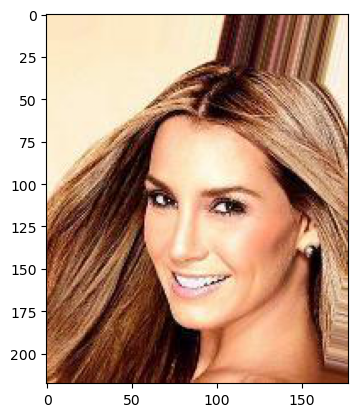

In [7]:
denorm = transforms.Normalize((-1,),(2,))

def im_show(img, ax=None):
    img_denorm = denorm(img)
    img_t = torch.permute(img_denorm, (1,2,0))
    img_t.clamp_(0, 1)
    if ax is not None:
        ax.imshow(img_t)
    else:
        plt.imshow(img_t)

img_example, label_example = dataset_train[0]
# plt.imshow(torch.permute(img_example[0], (1,2,0)))
im_show(img_example)
print(label_example)
print(img_example.size())

In [8]:
if not os.path.isdir(f'figures/{TARGET_ATTR}_{target_attr_index}/'):
    os.makedirs(f'figures/{TARGET_ATTR}_{target_attr_index}/')
attr_true_list_val = []
attr_false_list_val = []
cnt = [10, 10]
for i, (im, lab) in enumerate(dataset_val):
    l = lab[ATTR[TARGET_ATTR]].item()
    if l==1 and cnt[1] > 0:
        attr_true_list_val.append(i)
        cnt[1] -= 1
    elif l==0 and cnt[0] > 0:
        attr_false_list_val.append(i)
        cnt[0] -= 1
    if sum(cnt) == 0 : break
attr_true_list_train = []
attr_false_list_train = []
cnt = [10, 10]
for i, (im, lab) in enumerate(dataset_train):
    l = lab[ATTR[TARGET_ATTR]].item()
    if l==1 and cnt[1] > 0:
        attr_true_list_train.append(i)
        cnt[1] -= 1
    elif l==0 and cnt[0] > 0:
        attr_false_list_train.append(i)
        cnt[0] -= 1
    if sum(cnt) == 0 : break
print('Target Attribute: ', TARGET_ATTR)
print('True (Train): ', attr_true_list_train)
print('True (Val. ): ', attr_true_list_val)
print('False (Train): ', attr_false_list_train)
print('False (Val. ): ', attr_false_list_val)

Target Attribute:  Goatee
True (Train):  [19, 59, 108, 122, 135, 165, 205, 212, 228, 244]
True (Val. ):  [1, 12, 31, 40, 41, 63, 93, 111, 114, 128]
False (Train):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
False (Val. ):  [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]


### Ablation (Second moment gap rank)

In [9]:
from fair_streaming_pca import FairStreamingPCA

rank_list = [
    0, 1, 2, 5, 10
]
n_iter = 5
block_size = len(dataset_train) // n_iter

V_list = []
N_list = []
for r in rank_list:
    pca = FairStreamingPCA(TARGET_ATTR, device='mps')
    pca.fit(
        dataset=dataset_train,
        target_unfair_dim=r,
        target_pca_dim=1000,
        n_iter_unfair=n_iter,
        n_iter_pca=n_iter,
        block_size_unfair=block_size,
        block_size_pca=block_size,
        batch_size=1000,
        constraint='mean' if r=='mean' else ('all' if r > 0 else 'vanilla'),
        verbose=False,
        seed=0
    )
    V_list.append(pca.V.cpu())
    N_list.append(pca.N.cpu())

PCA::   0%|          | 0/5 [00:00<?, ?it/s]

UnfairEstim::   0%|          | 0/5 [00:00<?, ?it/s]

PCA::   0%|          | 0/5 [00:00<?, ?it/s]

UnfairEstim::   0%|          | 0/5 [00:00<?, ?it/s]

PCA::   0%|          | 0/5 [00:00<?, ?it/s]

UnfairEstim::   0%|          | 0/5 [00:00<?, ?it/s]

PCA::   0%|          | 0/5 [00:00<?, ?it/s]

UnfairEstim::   0%|          | 0/5 [00:00<?, ?it/s]

PCA::   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
if not os.path.isdir(f'Tensors/{TARGET_ATTR}_{target_attr_index}/rank_ablation/'):
    os.makedirs(f'Tensors/{TARGET_ATTR}_{target_attr_index}/rank_ablation/')
for i,r in enumerate(rank_list):
    torch.save(V_list[i], f'./Tensors/{TARGET_ATTR}_{target_attr_index}/rank_ablation/V_{r}.pt')
    torch.save(N_list[i], f'./Tensors/{TARGET_ATTR}_{target_attr_index}/rank_ablation/N_{r}.pt')

In [ ]:
V_list = []
N_list = []
rank_list = [
    0, 1, 2, 5, 10,
]
for i, r in enumerate(rank_list):
    V_list.append(torch.load(f'./Tensors/{TARGET_ATTR}_{target_attr_index}/rank_ablation/V_{r}.pt'))
    N_list.append(torch.load(f'./Tensors/{TARGET_ATTR}_{target_attr_index}/rank_ablation/N_{r}.pt'))

In [ ]:
from fair_streaming_pca import FairStreamingPCA

rank_list = [
    0, 1, 2, 5, 10
]
pca = FairStreamingPCA(TARGET_ATTR, device='mps')
plt.rcParams['font.size']=13
fig, axes = plt.subplots(2, len(rank_list), figsize=(2*len(rank_list), 5))
axes[0][0].set_ylabel('Span')
axes[1][0].set_ylabel('Orthogonal')
pca.device = 'mps'

for index in attr_false_list_val+attr_true_list_val:
    img, label = dataset_val[index]
    for i, r in enumerate(rank_list):
        pca.V = V_list[i].to(pca.device)
        projected = pca.transform(img).cpu()
        im_show(projected[0], axes[0][i])
        if r == 0:
            axes[0][i].title.set_text(f'Vanilla')
        elif r == 'mean':
            axes[0][i].title.set_text(f'mean')
        else:
            axes[0][i].title.set_text(f'FNPM (m={r})')
        axes[0][i].get_xaxis().set_ticks([])
        axes[0][i].get_yaxis().set_ticks([])
        if r == 'mean' or r > 0 :
            pca.V = N_list[i].to(pca.device)
            orthogonal = pca.transform(img).cpu()
            im_show(orthogonal[0], axes[1][i])
        else:
            im_show(img, axes[1][i]) # original
            axes[1][i].set_xlabel('(original)')
            
        axes[1][i].get_xaxis().set_ticks([])
        axes[1][i].get_yaxis().set_ticks([])

    fig.tight_layout()
    fig.savefig(f'figures/{TARGET_ATTR}_{ATTR[TARGET_ATTR]}/RankAblation_{bool(label[pca.a])}_val{index}.pdf')
    plt.close(fig)

In [ ]:
from fair_streaming_pca import FairStreamingPCA

rank_list = [
    0, 1, 2, 5, 10
]
pca = FairStreamingPCA(TARGET_ATTR, device='mps')
plt.rcParams['font.size']=13
fig, axes = plt.subplots(2, len(rank_list), figsize=(2*len(rank_list), 5))
axes[0][0].set_ylabel('Span')
axes[1][0].set_ylabel('Orthogonal')
pca.device = 'mps'

for index in attr_false_list_train+attr_true_list_train:
    img, label = dataset_train[index]
    for i, r in enumerate(rank_list):
        pca.V = V_list[i].to(pca.device)
        projected = pca.transform(img).cpu()
        im_show(projected[0], axes[0][i])
        if r == 0:
            axes[0][i].title.set_text(f'Vanilla')
        elif r == 'mean':
            axes[0][i].title.set_text(f'mean')
        else:
            axes[0][i].title.set_text(f'FNPM (m={r})')
        axes[0][i].get_xaxis().set_ticks([])
        axes[0][i].get_yaxis().set_ticks([])
        if r == 'mean' or r > 0 :
            pca.V = N_list[i].to(pca.device)
            orthogonal = pca.transform(img).cpu()
            im_show(orthogonal[0], axes[1][i])
        else:
            im_show(img, axes[1][i]) # original
            axes[1][i].set_xlabel('(original)')
            
        axes[1][i].get_xaxis().set_ticks([])
        axes[1][i].get_yaxis().set_ticks([])

    fig.tight_layout()
    fig.savefig(f'figures/{TARGET_ATTR}_{ATTR[TARGET_ATTR]}/RankAblation_{bool(label[pca.a])}_train{index}.pdf')
    plt.close(fig)